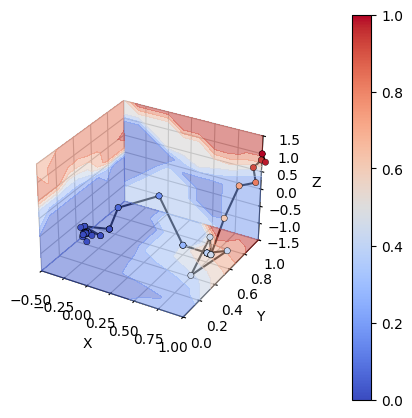

In [119]:

from scipy.optimize import minimize
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Example objective function (replace this with your MCC calculation function)
def objective_function(params):
    # Dummy objective function for demonstration purposes
    # return np.sum(params**2)
    return np.sum(np.sin(params**2))

# Initial guess for the parameters
initial_guess = np.array([1.0, 1.0, 1.0])

# Run the optimization with return_all=True
result = minimize(objective_function, initial_guess, method='Nelder-Mead', options={'return_all': True})

# Extract all intermediate results
all_results = np.array(result.allvecs)


values = np.array([objective_function(params) for params in all_results])
norm_values = (values - np.min(values)) / (np.max(values) - np.min(values))

X, Y, Z = all_results[:, 0], all_results[:, 1], all_results[:, 2]

x_range = [-0.5, 1.0]
y_range = [0, 1.0]
z_range = [-1.5, 1.5]

# Create figure, add subplot with 3d projection
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_zlim(z_range)

for i in range(len(all_results) - 1):
    ax.plot(all_results[i:i+2, 0], all_results[i:i+2, 1], all_results[i:i+2, 2], color='k')

# Plot the data cloud
sc = ax.scatter(X, Y, Z, alpha=1, c=norm_values, cmap='coolwarm', edgecolors='k', linewidth=0.3)

hist, binx, biny = np.histogram2d( X, Y)
x = np.linspace(*x_range, hist.shape[0])
y = np.linspace(*y_range, hist.shape[1])
x, y = np.meshgrid(x, y)
data = griddata((X, Y), Z, (x, y), method='linear')
data_nearest = griddata((X, Y), Z, (x, y), method='nearest')
data = np.where(np.isnan(data), data_nearest, data)
ax.contourf(x, y, data, zdir='z', offset=z_range[0], alpha=0.5, cmap="coolwarm")

hist, binx, biny = np.histogram2d( X, Z)
x = np.linspace(*x_range, hist.shape[0])
z = np.linspace(*z_range, hist.shape[1])
x, z = np.meshgrid(x, z)
data = griddata((X, Z), Y, (x, z), method='linear')
data_nearest = griddata((X, Z), Y, (x, z), method='nearest')
data = np.where(np.isnan(data), data_nearest, data)
ax.contourf(x, data, z, zdir='y', offset=y_range[1], alpha=0.5, cmap="coolwarm")

hist, binx, biny = np.histogram2d( Y, Z)
y = np.linspace(*y_range, hist.shape[0])
z = np.linspace(*z_range, hist.shape[1])
y, z = np.meshgrid(y, z)
data = griddata((Y, Z), X, (y, z), method='linear')
data_nearest = griddata((Y, Z), X, (y, z), method='nearest')
data = np.where(np.isnan(data), data_nearest, data)
data = np.flip(data, axis=1)
ax.contourf(data, y, z, zdir='x', offset=x_range[0], alpha=0.5, cmap="coolwarm")

cbar = plt.colorbar(sc, ax=ax, pad=0.2)


In [250]:
from scipy.optimize import OptimizeResult
from typing import Callable, List, Tuple
import numpy as np
import matplotlib as mpl

def optimization_plot_3d(
    results: List[OptimizeResult], 
    objective_function: Callable,
    ax,
    x_lim: Tuple[float, float] | None = None,
    y_lim: Tuple[float, float] | None = None,
    z_lim: Tuple[float, float] | None = None,
    objective_function_args: Tuple = (),
    cmap="coolwarm",
    interpolation_method: str = "linear",
    fill: bool = True
):
    x_lim = list(x_lim or (float(np.min(X)), float(np.max(X))))
    y_lim = list(y_lim or (float(np.min(Y)), float(np.max(Y))))
    z_lim = list(z_lim or (float(np.min(Z)), float(np.max(Z))))

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_zlim(z_lim)

    n_colors = 10
    discrete_cmap = mpl.colormaps[f"tab{n_colors}"]

    all_parameters = [np.array(result.allvecs) for result in results]
    
    for i, parameters in enumerate(all_parameters):
        color_index = i / (n_colors - 1)
        for i in range(len(parameters) - 1):
            ax.plot(
                parameters[i:i+2, 0], 
                parameters[i:i+2, 1], 
                parameters[i:i+2, 2], 
                color=discrete_cmap(color_index), 
                zorder=3.5
            )

    parameters = np.vstack(all_parameters)

    values = np.array([objective_function(params, *objective_function_args) for params in parameters])

    X, Y, Z = parameters[:, 0], parameters[:, 1], parameters[:, 2]

    # plot lines from last point to the axes:
    ax.plot([X[-1], X[-1]], [Y[-1], Y[-1]], [Z[-1], z_lim[0]], color='k', linestyle='--')
    ax.plot([X[-1], X[-1]], [Y[-1], y_lim[1]], [Z[-1], Z[-1]], color='k', linestyle='--')
    ax.plot([X[-1], x_lim[0]], [Y[-1], Y[-1]], [Z[-1], Z[-1]], color='k', linestyle='--')

    scatter_plot = ax.scatter(X, Y, Z, c=values, cmap=cmap, edgecolors='k', linewidth=0.3, zorder=5)
    plt.colorbar(scatter_plot, ax=ax, pad=0.2)
    count = -1
    for points, values, lims, zdir, args_order in zip(
        ((X, Y), (X, Z), (Y, Z)), 
        (Z, Y, X),
        ((x_lim, y_lim, z_lim), (x_lim, z_lim, y_lim), (y_lim, z_lim, x_lim)),
        ("z", "y", "x"),
        ((0, 1, 2), (0, 2, 1), (2, 0, 1))
    ):
        hist, *_ = np.histogram2d(*points)
        dim_0 = np.linspace(*lims[0], hist.shape[0])
        dim_1 = np.linspace(*lims[1], hist.shape[1])
        dim_0, dim_1 = np.meshgrid(dim_0, dim_1)

        data = griddata(points, values, (dim_0, dim_1), method=interpolation_method)
        if fill and interpolation_method != "nearest":
            data_nearest = griddata(points, values, (dim_0, dim_1), method="nearest")
            data = np.where(np.isnan(data), data_nearest, data)
        args = [[dim_0, dim_1, data][i] for i in args_order]
        
        ax.contourf(
            *args, zdir=zdir, offset=lims[2][1 if zdir == "y" else 0], alpha=0.5, cmap=cmap,    zorder=count
        )
        count += -1


107


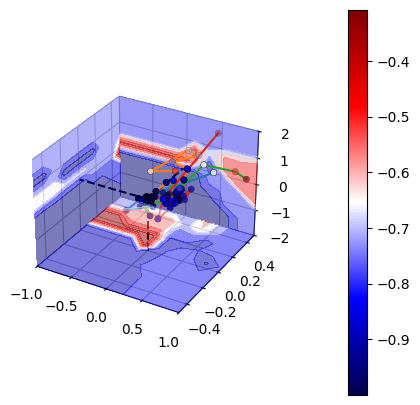

In [251]:

from scipy.optimize import minimize
from random import random

def objective_function(params):    
    return np.mean(params**2) * 2 - 1

results = []
for _ in range(4):
    initial_simplex = [
        [random(), random(), random()],
        [random(), random(), random()],
        [random(), random(), random()],
        [random(), random(), random()]
    ]
    result = minimize(objective_function, initial_simplex[0], method='Nelder-Mead', options={'return_all': True, 'initial_simplex': np.array(initial_simplex)})
    results.append(result)
# result = minimize(objective_function, initial_guess, method='Nelder-Mead', options={'return_all': True, 'initial_simplex': np.array(initial_simplex)})

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

x_range = [-1, 1.0]
y_range = [-0.5, 0.5]
z_range = [-2, 2]

print(len(result.allvecs))

optimization_plot_3d(
    results, 
    objective_function, 
    ax, 
    x_lim=x_range, y_lim=y_range, z_lim=z_range,
    interpolation_method="linear",
    cmap="seismic",
    fill=True
)
